In [1]:
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark as ps
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from scripts import datapipe

plt.style.use('ggplot')

In [2]:
spark = (ps.sql.SparkSession.builder
            .master('local[4]')
            .appName('sparkSQL')
            .getOrCreate())

sc = spark.sparkContext

In [3]:
type(spark)

pyspark.sql.session.SparkSession

In [4]:
#df = spark.read.csv('/media/austin/Ubuntu-2/postgres_i502/raw_data/I502/Areas_0.csv'
#                    ,header=True
#                    , sep='\t'
#                    , encoding='UTF-16')

In [5]:
df = spark.read.options(header='true', inferSchema='true', sep='\t', encoding='UTF-16') \
          .csv('/media/austin/Ubuntu-2/postgres_i502/raw_data/I502/LabResults_0.csv')

In [6]:
print(df.printSchema())

root
 |-- global_id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- mme_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- external_id: string (nullable = true)
 |-- deleted_at: timestamp (nullable = true)
 |-- inventory_id: string (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- status: string (nullable = true)
 |-- testing_status: string (nullable = true)
 |-- batch_id: string (nullable = true)
 |-- for_mme_id: string (nullable = true)
 |-- parent_lab_result_id: string (nullable = true)
 |-- og_parent_lab_result_id: string (nullable = true)
 |-- copied_from_lab_id: string (nullable = true)
 |-- lab_user_id: string (nullable = true)
 |-- tested_at: timestamp (nullable = true)
 |-- received_at: timestamp (nullable = true)
 |-- type: string (nullable = true)
 |-- foreign_matter: boolean (nullable = true)
 |-- moisture_content_percent: double (nullable = true)
 |-- herbicides_ppm: double (nullable = true)
 |-- growth_re

In [7]:
# remove "�" from dataset. Pandas read this in fine, but pyspark will not.
df = df.filter(~col("global_id").like("%�%"))
remove_last_char_in_str = udf(lambda x: x[:-1], StringType())
df = (df.withColumn(df.columns[-1], remove_last_char_in_str(df.columns[-1])));

In [8]:
df.createOrReplaceTempView('lab_tests')

In [9]:
df.first()

Row(global_id='WAJ412964.LR2', created_at=datetime.datetime(2018, 1, 31, 22, 36, 20), mme_id='WAWA1.MMCY', user_id='WAWA1.US29D', external_id='4129640000001061', deleted_at=None, inventory_id='WAJ412964.ING1', updated_at=datetime.datetime(2018, 1, 31, 22, 36, 20), status='passed', testing_status='completed', batch_id='WAJ412964.BA1LC', for_mme_id='WAWA1.MMCY', parent_lab_result_id=None, og_parent_lab_result_id=None, copied_from_lab_id=None, lab_user_id='WAWA1.US29D', tested_at=datetime.datetime(2017, 11, 13, 0, 36), received_at=datetime.datetime(1900, 1, 1, 0, 0), type='harvest_materials', foreign_matter=False, moisture_content_percent=4.9, herbicides_ppm=0.0, growth_regulators_ppm=0.0, cannabinoid_status='completed', cannabinoid_editor=None, cannabinoid_d9_thca_percent=19.77, cannabinoid_d9_thca_mg_g=None, cannabinoid_d9_thc_percent=0.32, cannabinoid_d9_thc_mg_g=None, cannabinoid_d8_thc_percent=0.0, cannabinoid_d8_thc_mg_g=None, cannabinoid_thcv_percent=0.0, cannabinoid_thcv_mg_g=None

In [10]:
result = spark.sql('''SELECT global_id
                    , created_at
                    , mme_id
                    , user_id
                    , external_id
                    , inventory_id
                    , updated_at
                    , status
                    , testing_status
                    , batch_id
                    , for_mme_id
                    , lab_user_id
                    , type
                    , cannabinoid_status
                    , cannabinoid_editor
                    , cannabinoid_d9_thc_percent
                    , cannabinoid_cbd_percent
                    , cannabinoid_cbda_percent
                    FROM lab_tests
                    WHERE created_at > CAST("2020-01-01" AS DATE)
                   ''')
result.show()

+-------------+-------------------+-----------+-----------+----------------+-------------+-------------------+------+--------------+-------------+-----------+-----------+--------------------+------------------+------------------+--------------------------+-----------------------+------------------------+
|    global_id|         created_at|     mme_id|    user_id|     external_id| inventory_id|         updated_at|status|testing_status|     batch_id| for_mme_id|lab_user_id|                type|cannabinoid_status|cannabinoid_editor|cannabinoid_d9_thc_percent|cannabinoid_cbd_percent|cannabinoid_cbda_percent|
+-------------+-------------------+-----------+-----------+----------------+-------------+-------------------+------+--------------+-------------+-----------+-----------+--------------------+------------------+------------------+--------------------------+-----------------------+------------------------+
|WAL20.LR13GJS|2020-01-01 05:33:50|WAWA1.MM1VC|WAWA1.US2VM|   P191227-4 001|WAL20.

In [11]:
df_pandas = result.toPandas()

In [12]:
df_pandas.to_csv('lab_results_all')

In [13]:
df_pandas.head()

,global_id,created_at,mme_id,user_id,external_id,inventory_id,updated_at,status,testing_status,batch_id,for_mme_id,lab_user_id,type,cannabinoid_status,cannabinoid_editor,cannabinoid_d9_thc_percent,cannabinoid_cbd_percent,cannabinoid_cbda_percent
0,WAL20.LR13GJS,2020-01-01 05:33:50,WAWA1.MM1VC,WAWA1.US2VM,P191227-4 001,WAL20.INFMAK8,2020-01-01 05:33:51,passed,completed,WAL20.BAFRDM6,WAWA1.MMD8,WAWA1.US2VM,harvest_materials,completed,NaN,0.465,0.0,0.0
1,WAL20.LR13GJT,2020-01-01 05:33:51,WAWA1.MM1VC,WAWA1.US2VM,P191227-4 002,WAL20.INFMAK9,2020-01-01 05:33:51,passed,completed,WAL20.BAFRDM7,WAWA1.MMD8,WAWA1.US2VM,intermediate_product,completed,NaN,18.137,0.0,0.0
2,WAL20.LR13GJU,2020-01-01 05:33:51,WAWA1.MM1VC,WAWA1.US2VM,P191227-4 003,WAL20.INFMAKA,2020-01-01 05:33:51,passed,completed,WAL20.BAFRDM8,WAWA1.MMD8,WAWA1.US2VM,end_product,completed,NaN,0.102,0.0,0.0
3,WAL3.LR13GJV,2020-01-01 22:13:10,WAWA1.MM1L2,WAWA1.US2IP,None,WAL3.INFPXAD,2020-01-03 09:28:50,failed,in_progress,WAL3.BAFUARZ,WAWA1.MMX7,WAWA1.US2IP,marijuana,None,NaN,NaN,NaN,NaN
4,WAL3.LR13GJW,2020-01-01 22:14:33,WAWA1.MM1L2,WAWA1.US2IP,None,WAL3.INFPXAN,2020-01-05 12:20:24,failed,in_progress,WAL3.BAFUASE,WAWA1.MMUT,WAWA1.US2IP,marijuana,None,NaN,NaN,NaN,NaN


In [14]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141138 entries, 0 to 141137
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   global_id                   141138 non-null  object        
 1   created_at                  141138 non-null  datetime64[ns]
 2   mme_id                      141138 non-null  object        
 3   user_id                     141138 non-null  object        
 4   external_id                 93005 non-null   object        
 5   inventory_id                141138 non-null  object        
 6   updated_at                  141138 non-null  datetime64[ns]
 7   status                      141138 non-null  object        
 8   testing_status              141135 non-null  object        
 9   batch_id                    141138 non-null  object        
 10  for_mme_id                  141138 non-null  object        
 11  lab_user_id                 141138 non-

In [15]:
df_pandas['lab_user_id'].value_counts()

WAWA1.US2GL    26147
WAWA1.US2VM    20238
WAWA1.US3IK    18564
WAWA1.US2IP    15568
WAWA1.US2F3    14106
WAWA1.US2CT    11478
WAWA1.USFGJ     7170
WAWA1.US2D7     4197
WAWA1.US2H2     3946
WAWA1.US2EZ     3871
WAWA1.US2TE     3654
WAWA1.US3QA     2392
WAWA1.US2SZ     1480
WAWA1.US2EW     1243
WAWA1.US357     1173
WAWA1.US3J6     1099
WAWA1.US3O9      899
WAWA1.US2TA      815
WAWA1.US3MH      609
WAWA1.US2TO      399
WAWA1.US3EH      318
WAWA1.US3I6      286
WAWA1.USAH9      243
WAWA1.US46A      181
WAWA1.US386      179
WAWA1.US2O9      137
WAWA1.USHG8      136
WAWA1.US5JP      124
WAWA1.US2EX       73
WAWA1.US3QC       54
WAWA1.US7B2       50
WAWA1.US2UM       45
WAWA1.US3RV       44
WAWA1.US2UE       43
WAWA1.US2F0       40
WAWA1.US2SY       35
WAWA1.US7B0       27
WAWA1.US2TQ       23
WAWA1.USHD5       17
WAWA1.US2G2       13
WAWA1.USK7H        7
WAWA1.US388        7
WAWA1.USHD6        4
WAWA1.US3QD        1
WAWA1.US2EM        1
WAWA1.US30E        1
WAWA1.US2SX        1
Name: lab_use

In [16]:
df_pandas['cannabinoid_d9_thc_percent'].value_counts()

0.600     5851
0.700     5460
0.500     4505
0.800     4486
0.000     4369
          ... 
3.315        1
29.560       1
5.007        1
79.181       1
22.016       1
Name: cannabinoid_d9_thc_percent, Length: 12468, dtype: int64

In [17]:
df_pandas['cannabinoid_d9_thc_percent'].value_counts()

0.600     5851
0.700     5460
0.500     4505
0.800     4486
0.000     4369
          ... 
3.315        1
29.560       1
5.007        1
79.181       1
22.016       1
Name: cannabinoid_d9_thc_percent, Length: 12468, dtype: int64

In [18]:
df_pandas['type'].value_counts()

harvest_materials       95904
intermediate_product    27660
end_product             13851
marijuana                3701
mature_plant               22
Name: type, dtype: int64

In [19]:
df_pandas['cannabinoid_editor'].value_counts()

4542.0     17696
3135.0     14238
3053.0     13025
3129.0      6325
3206.0      4604
3132.0      4219
3650.0      4102
4761.0      1378
3128.0      1220
4556.0      1129
4182.0       924
3118.0       815
3634.0       814
0.0          667
3189.0       266
9468.0       162
7189.0       124
9470.0        50
4891.0        44
13581.0       25
3731.0        19
22505.0       19
4697.0        17
4184.0        15
4409.0        11
5410.0         9
3184.0         6
22616.0        2
4181.0         1
16155.0        1
3271.0         1
4836.0         1
Name: cannabinoid_editor, dtype: int64

In [20]:
df_mj = df_pandas[df_pandas['type'] == 'marijuana']
df_end_product = df_pandas[df_pandas['type'] == 'end_product']
df_harvest = df_pandas[df_pandas['type'] == 'intermediate_product']

In [21]:
def ecdf_graph(ax, data):
    """Compute and graph ECDF for a one-dimensional vector."""
    # Number of data points: n
    data = np.array(data)
    data = data[data <= 100]
    data = data[data <= 1] * 100 # some percentages are in decimal form
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n

    ax.plot(x,y)

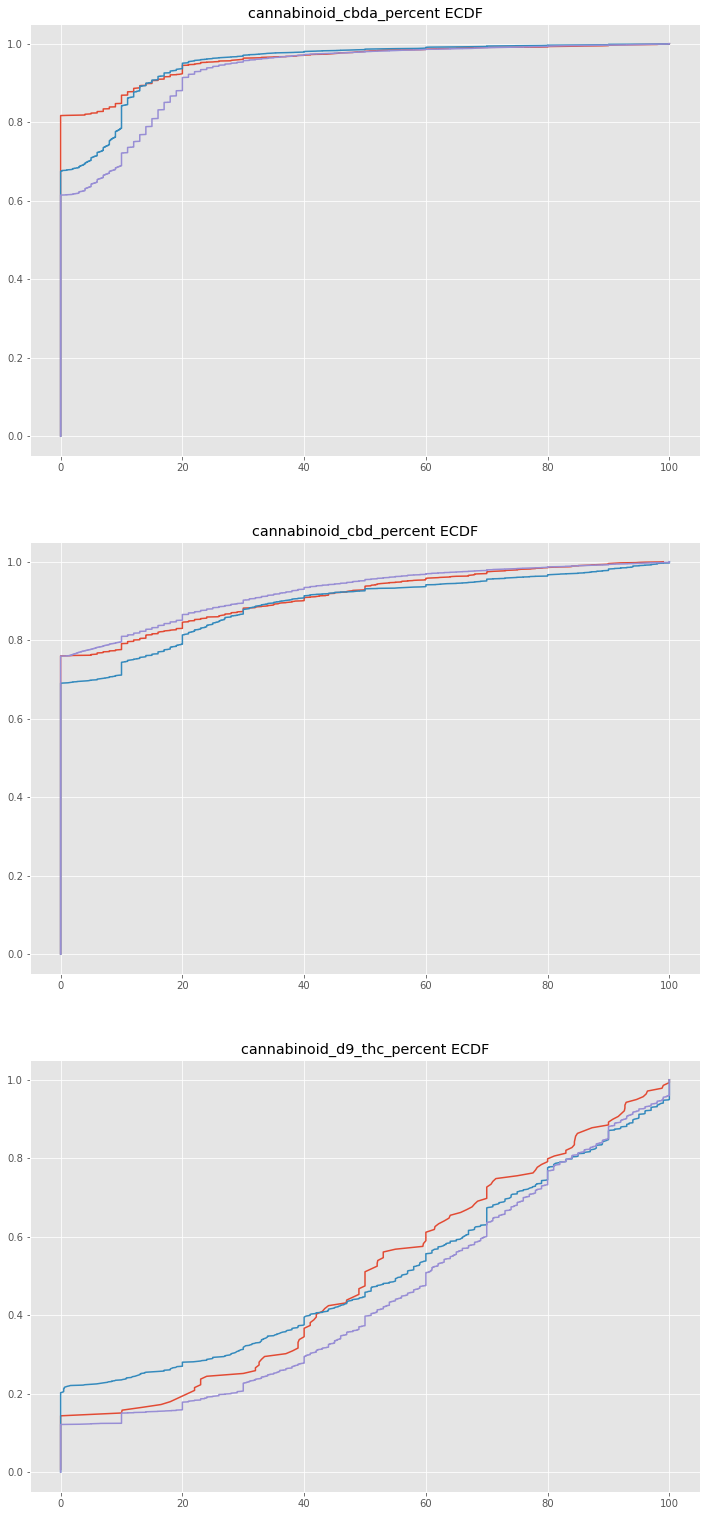

In [22]:
n_graphs = 3
fig, axs = plt.subplots(n_graphs, 1, figsize=(12,9*n_graphs))

for i,ax in enumerate(axs.flatten()):
    ecdf_graph(ax, df_mj[df_mj.columns[-i-1]])
    ecdf_graph(ax, df_end_product[df_end_product.columns[-i-1]])
    ecdf_graph(ax, df_harvest[df_harvest.columns[-i-1]])
    #ax.hist(df_pandas[df_pandas.columns[-i-1]] * 100)
    ax.set_title(f'{df_end_product.columns[-i-1]} ECDF')    

In [23]:
df_harvest_gb = df_harvest.groupby('lab_user_id')

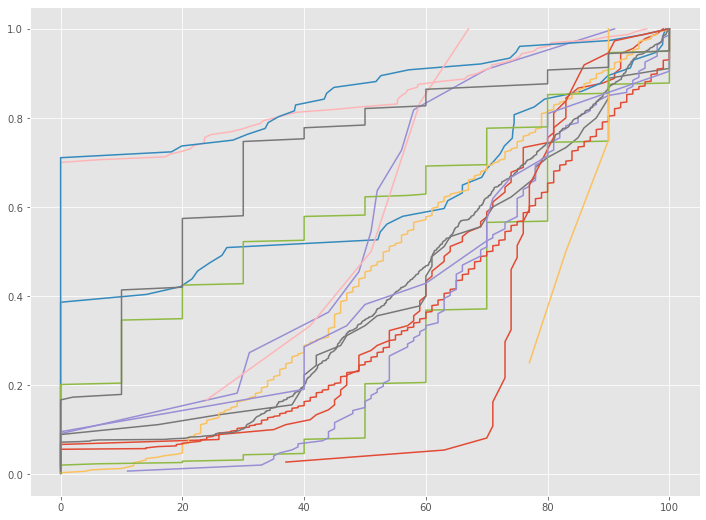

In [24]:
fig, ax = plt.subplots(figsize=(12,9))
for group_id, group in df_harvest_gb:
    if len(group['cannabinoid_d9_thc_percent']) > 100:
        ecdf_graph(ax, group['cannabinoid_d9_thc_percent'])

In [25]:
class f_string:
    def __init__(self, month, str_):
        self.month = month
        self.str = str_
        self.formatted = self.str.format(self.month)

f_string(1, 't{}').formatted

't1'

In [26]:
np.array?